In [1]:
!pip install sh

  Using cached sh-1.14.1-py2.py3-none-any.whl (40 kB)


In [5]:
%run imports.ipynb
from os.path import join, isdir, isfile
import sh

In [6]:
root_dir = "/home/jovyan/notebooks/Far_West/admixture"
wd = join(root_dir, "preprocessed_data", "PLINK_v1.07")
sh.mkdir("-p", wd)

In [7]:
def estimate_gdist(pos, table):
    which = np.searchsorted(table.pposition.tolist(), pos + 1)    
    gap = pos - table.iloc[which - 1].pposition
    rate = table.iloc[which - 1].rrate
    return np.round(table.iloc[which - 1].gposition + ((gap/1e6) * rate), 7)

In [8]:
def loadmap(path):
    mapdata = pd.read_csv(path, sep="\t", index_col=None)
    return mapdata

In [9]:
mapfn = join("admixture/map/Ag_{chrom}.map")

In [10]:
from anhima import loc, gt
import gzip

In [11]:
meta_fn = "samples.meta.txt"
dat = pd.read_csv(meta_fn, sep="\t", index_col=0)

In [12]:
dat = dat[dat.population != 'AOcol'] 
dat = dat[dat.population != 'CMgam'] 
dat = dat[dat.population != 'FRgam'] 
dat = dat[dat.population != 'GAgam'] 
dat = dat[dat.population != 'GQgam'] 
dat = dat[dat.population != 'KE'] 
dat = dat[dat.population != 'UGgam'] 
dat

,src_code,population,country,location,site,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,ebi_sample_acc,latitude,longitude
ox_code,,,,,,,,,,,,,,,
AA0040-C,Twifo_Praso__E2,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95033368,30.99,ERS311878,5.60858,-1.54926
AA0041-C,Twifo_Praso__H3,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95843804,31.70,ERS311886,5.60858,-1.54926
AA0042-C,Takoradi_C7,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,107420666,35.65,ERS311894,4.91217,-1.77397
AA0043-C,Takoradi_H8,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,95993752,29.46,ERS311902,4.91217,-1.77397
AA0044-C,Takoradi_D10,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,103044262,33.67,ERS311910,4.91217,-1.77397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AY0087-C,Tia_dPM_46,CIcol,Cote d'Ivoire,Tiassale,Tiassale,David Weetman,David Weetman,2012,M,F,101458232,32.56,ERS311822,5.89839,-4.82293
AY0088-C,Tia_dPM_52,CIcol,Cote d'Ivoire,Tiassale,Tiassale,David Weetman,David Weetman,2012,M,F,95140584,30.75,ERS311830,5.89839,-4.82293
AY0089-C,Tia_aPM_4,CIcol,Cote d'Ivoire,Tiassale,Tiassale,David Weetman,David Weetman,2012,M,F,92383724,29.04,ERS311838,5.89839,-4.82293


In [13]:
dat.to_csv('meta.csv')

In [14]:
sex_d = {"F": "2", "M": "1"}
fstem = "{chrom}_{desc}_{start}_{stop}"

In [15]:
callset_fn = callset_biallel

In [16]:
script_d = join(wd, "_script")
log_d = join(wd, "_log")
sh.mkdir("-p", script_d, log_d)

In [17]:
plink_cmd = """
#! /bin/bash

set -e 
set -o pipefail

cd {wd}
gunzip {file}.ped.gz {file}.map.gz
plink --noweb --file {file} --out {file}.ld --indep-pairwise {nsnps} {slide} {r2}

shuf -n 200000 {file}.ld.prune.in | sort > {file}.ld.prune.in.downsample

plink --noweb --file {file} --extract {file}.ld.prune.in.downsample \\
  --out {file}.ld.pruned --make-bed
plink --noweb --file {file} --extract {file}.ld.prune.in.downsample \\
  --out {file}.ld.pruned --recode

gzip {file}.ped {file}.map
"""

In [18]:
maf_min = 0.01
r2_value = 0.1
downsample_n = 100000

In [ ]:
regions = (("3R", 1, 24_000_000, "free"),
           ("3L", 18_000_000, 41_000_000, "free"))

In [20]:
pop_selection = metadata.population.isin({'GHcol', 'GHgam', 'BFgam', 'BFcol', 'GM', 'GW', 'GNgam', 'GNcol',
       'CIcol'}).values

---------------------------------

## 3R

In [21]:
fh = callset_fn['3R']

In [22]:
from itertools import compress

In [23]:
fh_samples = [str(s) for s in callset_fn['3R']["samples"][:]]
fh_samples = list(compress(fh_samples, pop_selection))

In [24]:
len(list(compress(fh_samples, pop_selection)))

390

In [25]:
g = allel.GenotypeChunkedArray(fh['calldata/GT']).subset(sel1=pop_selection)
g

<GenotypeChunkedArray shape=(10752701, 505, 2) dtype=int8 chunks=(5251, 505, 2)
   nbytes=10.1G cbytes=472.9M cratio=21.9
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [26]:
positions = fh['variants']['POS'][:]
loci = (positions >= 1) & (positions <= 24_000_000)

In [27]:
g =g.compress(loci, axis=0)

In [28]:
pos = np.compress(loci, positions)
positions = None

In [29]:
alleles = g.count_alleles()

In [30]:
biallelic = alleles.max_allele() <= 1
g = g.compress(biallelic, axis=0)
pos = np.compress(np.array(biallelic), pos)

In [31]:
freqs = g.count_alleles().to_frequencies()
maf_ok = np.min(np.array(freqs), axis=1) >= maf_min
g = g.compress(maf_ok, axis=0)
pos = np.compress(maf_ok, pos, axis=0)

In [32]:
if pos.size > downsample_n:
        print("Downsampling... to {0} from {1}".format(downsample_n, pos.size))
        idx = np.random.choice(np.arange(0, pos.size), downsample_n, False)
        idx.sort()
        pos = np.take(pos, idx)
        g = g.take(idx, axis=0)

Downsampling... to 100000 from 865193


In [33]:
g_3R = g
g_3R

<GenotypeChunkedArray shape=(100000, 505, 2) dtype=int8 chunks=(782, 505, 2)
   nbytes=96.3M cbytes=20.2M cratio=4.8
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

--------------------------------------
## 3L

In [34]:
fh = callset_fn['3L']

In [35]:
from itertools import compress

In [36]:
fh_samples = [str(s) for s in callset_fn['3L']["samples"][:]]
fh_samples = list(compress(fh_samples, pop_selection))

In [37]:
len(list(compress(fh_samples, pop_selection)))

390

In [38]:
g = allel.GenotypeChunkedArray(fh['calldata/GT']).subset(sel1=pop_selection)
g

<GenotypeChunkedArray shape=(7897666, 505, 2) dtype=int8 chunks=(3857, 505, 2)
   nbytes=7.4G cbytes=340.1M cratio=22.4
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [39]:
positions = fh['variants']['POS'][:]
loci = (positions >= 18_000_000) & (positions <= 41_000_000)

In [40]:
g =g.compress(loci, axis=0)
g

<GenotypeChunkedArray shape=(5358122, 505, 2) dtype=int8 chunks=(2617, 505, 2)
   nbytes=5.0G cbytes=220.5M cratio=23.4
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [41]:
pos = np.compress(loci, positions)
positions = None

In [42]:
alleles = g.count_alleles()

In [43]:
biallelic = alleles.max_allele() <= 1
g = g.compress(biallelic, axis=0)
pos = np.compress(np.array(biallelic), pos)

In [44]:
freqs = g.count_alleles().to_frequencies()
maf_ok = np.min(np.array(freqs), axis=1) >= maf_min
g = g.compress(maf_ok, axis=0)
pos = np.compress(maf_ok, pos, axis=0)

In [45]:
if pos.size > downsample_n:
        print("Downsampling... to {0} from {1}".format(downsample_n, pos.size))
        idx = np.random.choice(np.arange(0, pos.size), downsample_n, False)
        idx.sort()
        pos = np.take(pos, idx)
        g = g.take(idx, axis=0)

Downsampling... to 100000 from 812252


In [46]:
g_3L = g
g_3L

<GenotypeChunkedArray shape=(100000, 505, 2) dtype=int8 chunks=(782, 505, 2)
   nbytes=96.3M cbytes=20.2M cratio=4.8
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

------------------------------
## Merge two genomes

In [47]:
g_3R

<GenotypeChunkedArray shape=(100000, 505, 2) dtype=int8 chunks=(782, 505, 2)
   nbytes=96.3M cbytes=20.2M cratio=4.8
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [48]:
g_3L

<GenotypeChunkedArray shape=(100000, 505, 2) dtype=int8 chunks=(782, 505, 2)
   nbytes=96.3M cbytes=20.2M cratio=4.8
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [49]:
chrom_3 = np.vstack((g_3R, g_3L))
chrom_3 =allel. GenotypeChunkedArray(chrom_3)

In [50]:
chrom_3

<GenotypeChunkedArray shape=(200000, 505, 2) dtype=int8
   nbytes=192.6M
   values=numpy.ndarray>

--------------------------------------------------
## Admixture

In [54]:
chrom = ["2R", '2L', '3R', '3L', 'X']

In [69]:
fn = ("ped.gz")
if not isfile(fn + ".ok"):
        with gzip.open(fn, "wb") as gz:
            for i, sid in enumerate(fh_samples):
                sex = sex_d[dat.loc[sid].sex]
                if (chrom == "X") and (sex == "1"):
                    continue
                geno = np.array(chrom_3[:, i] + 1)
                geno_str = " ".join(np.apply_along_axis(" ".join, 1, geno.astype("str")))
                line = " ".join([sid, sid, "0", "0", sex, "0", geno_str]) + "\n"
                gz.write(line.encode())
        
sh.touch(join(wd, fn + ".ok"))

-----------------------------------------
## PCA

In [57]:
chrom_3

<GenotypeChunkedArray shape=(200000, 505, 2) dtype=int8
   nbytes=192.6M
   values=numpy.ndarray>

In [46]:
ac = chrom_3.count_alleles()[:]
ac

<AlleleCountsArray shape=(200000, 2) dtype=int32>
957  53
972  38
484 526
...
994  16
 26 984
997  13

In [47]:
gn = chrom_3.to_n_alt()
gn

<ChunkedArrayWrapper shape=(200000, 505) dtype=int8 chunks=(1563, 505)
   nbytes=96.3M cbytes=29.0M cratio=3.3
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [48]:
def ld_prune(gn, size, step, threshold=.1, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.locate_unlinked(gn, size=size, step=step, threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
    return gn

In [49]:
gnu = ld_prune(gn, size=500, step=200, threshold=.1, n_iter=5)

iteration 1 retaining 157415 removing 42585 variants
iteration 2 retaining 156851 removing 564 variants
iteration 3 retaining 156706 removing 145 variants
iteration 4 retaining 156644 removing 62 variants
iteration 5 retaining 156635 removing 9 variants


In [50]:
coords, model = allel.pca(gnu, n_components=10, scaler='patterson')

In [51]:
dat.population.unique()

array(['GHcol', 'GHgam', 'BFgam', 'BFcol', 'GM', 'GW', 'GNgam', 'GNcol',
       'CIcol'], dtype=object)

In [52]:
pop_colours = {
    'GHgam': sns.color_palette('Blues', 3)[1],
    'BFgam': sns.color_palette('Blues', 5)[1],
    'GNgam': sns.color_palette('Blues', 2)[0],
    'GM': sns.color_palette('Greens', 2)[1],
    'GW': sns.color_palette('Greens', 2)[0],
    'GNcol': sns.color_palette('Reds', 7)[1],
    'CIcol': sns.color_palette('Reds', 3)[2],
    'GHcol': sns.color_palette('Reds', 5)[2],
    'BFcol': sns.color_palette('Reds', 1)[0],
}

In [53]:
populations = ['GHcol', 'GHgam', 'BFgam', 'BFcol', 'GM', 'GW', 'GNgam', 'GNcol', 'CIcol']

In [54]:
def plot_pca_coords(coords, model, pc1, pc2, ax, sample_population):
    sns.despine(ax=ax, offset=5)
    x = coords[:, pc1]
    y = coords[:, pc2]
    for pop in populations:
        flt = (sample_population == pop)
        ax.plot(x[flt], y[flt], marker='o', linestyle='', mec=pop_colours[pop], mfc='none', mew=2.5, label=pop, markersize=3)
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))
    

def fig_pca(coords, model, title, sample_population=None):
    if sample_population is None:
        sample_population = dat.population.values
    fig, ax = plt.subplots()
    y = model.explained_variance_
    x = np.arange(1, len(y)+1)
    ax.plot(x, y, 'ko')
    ax.set_xticks(x)
    ax.set_xlabel('principal component')
    ax.set_ylabel('variance explained')
    ax.grid(axis='x')
    # plot coords for PCs 1 vs 2, 3 vs 4
    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(2, 3, 1)
    plot_pca_coords(coords, model, 0, 1, ax, sample_population)
    ax = fig.add_subplot(2, 3, 2)
    plot_pca_coords(coords, model, 2, 3, ax, sample_population)
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    fig.suptitle(title, y=1.02)
    fig.tight_layout()

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


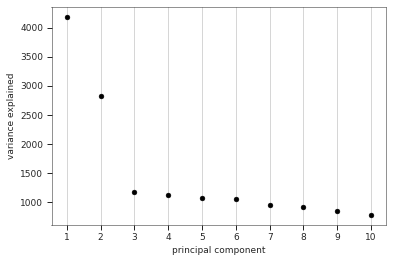

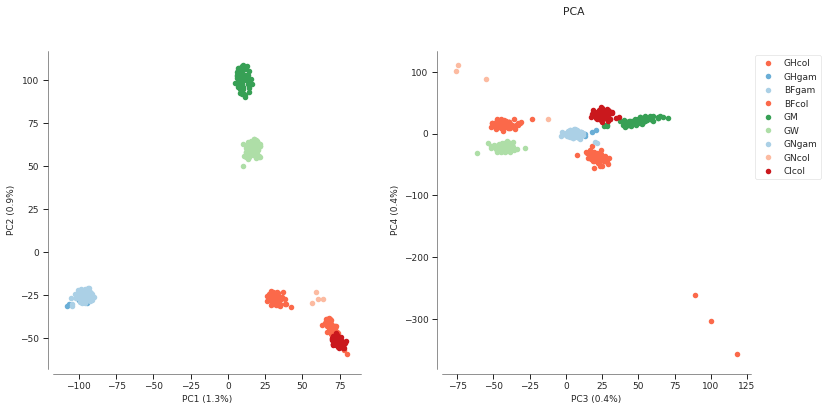

In [65]:
fig_pca(coords, model, 'PCA')

In [99]:
pop_colours = {
    'GHgam': '#0099ff',
    'BFgam': '#66ccff',
    'GNgam': '#000099',
    'GM': '#cc99ff',
    'GW': '#9933ff',
    'GNcol': sns.color_palette('Reds', 7)[1],
    'CIcol': sns.color_palette('Reds', 3)[2],
    'GHcol': '#ff6666',
    'BFcol':'#ffcc00',
}

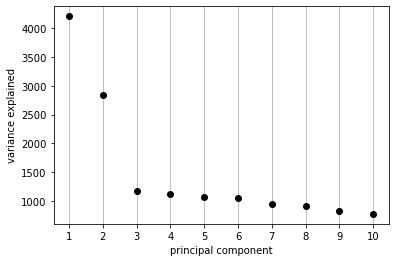

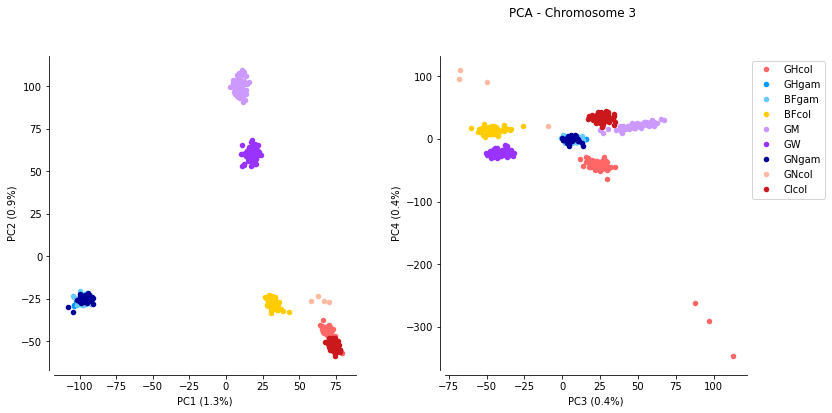

In [100]:
fig_pca(coords, model, 'PCA - Chromosome 3')

---------------------------------

In [54]:
dat.population.unique()

array(['GHcol', 'GHgam', 'BFgam', 'BFcol', 'GM', 'GW', 'GNgam', 'GNcol',
       'CIcol'], dtype=object)

In [64]:
pop_subset = dat.reset_index()

In [65]:
len(pop_subset)

505

In [66]:
subpops = {
    'all': list(range(len(pop_subset))),
    'BFcol': pop_subset[pop_subset.population == 'BFcol'].index.tolist(),
    'BFgam': pop_subset[pop_subset.population == 'BFgam'].index.tolist(),
    'GHcol': pop_subset[pop_subset.population == 'GHcol'].index.tolist(),
    'GHgam': pop_subset[pop_subset.population == 'GHgam'].index.tolist(),
    'GM': pop_subset[pop_subset.population == 'GM'].index.tolist(),
    'GW': pop_subset[pop_subset.population == 'GW'].index.tolist(),
    'GNgam': pop_subset[pop_subset.population == 'GNgam'].index.tolist(),
    'GNcol': pop_subset[pop_subset.population == 'GNcol'].index.tolist(),
    'CIcol': pop_subset[pop_subset.population == 'CIcol'].index.tolist(),
}

In [68]:
%%time
ac_subpops = chrom_3.count_alleles_subpops(subpops)

CPU times: user 3.45 s, sys: 7.88 ms, total: 3.45 s
Wall time: 3.45 s


In [69]:
is_seg = ac_subpops['all'].is_segregating()[:]
is_seg

array([ True,  True,  True, ...,  True,  True,  True])

In [70]:
genotypes_seg = chrom_3.compress(is_seg, axis=0)
genotypes_seg

<GenotypeChunkedArray shape=(200000, 505, 2) dtype=int8 chunks=(1563, 505, 2)
   nbytes=192.6M cbytes=40.4M cratio=4.8
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [74]:
is_biallelic_01 = ac_subpops['all'].is_biallelic_01()[:]
ac1 = ac_subpops['BFcol'].compress(is_biallelic_01, axis=0)[:, :2]
ac2 = ac_subpops['BFgam'].compress(is_biallelic_01, axis=0)[:, :2]
ac3 = ac_subpops['GHcol'].compress(is_biallelic_01, axis=0)[:, :2]
ac4 = ac_subpops['GHgam'].compress(is_biallelic_01, axis=0)[:, :2]
ac5 = ac_subpops['GM'].compress(is_biallelic_01, axis=0)[:, :2]
ac6 = ac_subpops['GW'].compress(is_biallelic_01, axis=0)[:, :2]
ac7 = ac_subpops['GNgam'].compress(is_biallelic_01, axis=0)[:, :2]
ac8 = ac_subpops['GNcol'].compress(is_biallelic_01, axis=0)[:, :2]
ac9 = ac_subpops['CIcol'].compress(is_biallelic_01, axis=0)[:, :2]

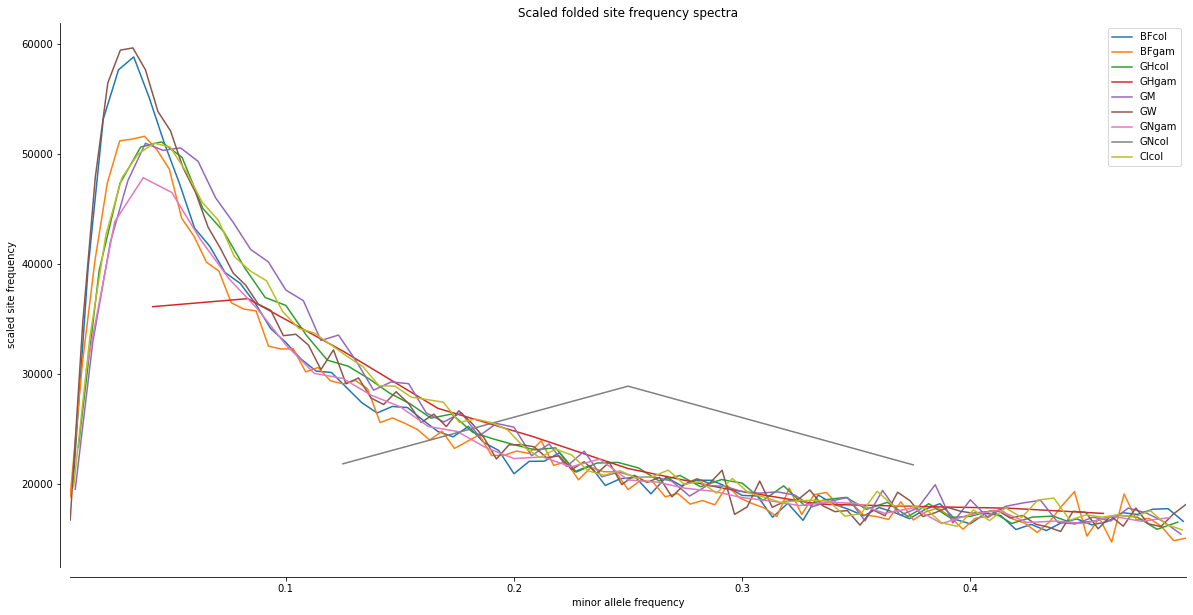

In [81]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.despine(ax=ax, offset=10)
sfs1 = allel.sfs_folded_scaled(ac1)
allel.plot_sfs_folded_scaled(sfs1, ax=ax, label='BFcol', n=ac1.sum(axis=1).max())
sfs2 = allel.sfs_folded_scaled(ac2)
allel.plot_sfs_folded_scaled(sfs2, ax=ax, label='BFgam', n=ac2.sum(axis=1).max())
sfs3 = allel.sfs_folded_scaled(ac3)
allel.plot_sfs_folded_scaled(sfs3, ax=ax, label='GHcol', n=ac3.sum(axis=1).max())
sfs4 = allel.sfs_folded_scaled(ac4)
allel.plot_sfs_folded_scaled(sfs4, ax=ax, label='GHgam', n=ac4.sum(axis=1).max())
sfs5 = allel.sfs_folded_scaled(ac5)
allel.plot_sfs_folded_scaled(sfs5, ax=ax, label='GM', n=ac5.sum(axis=1).max())
sfs6 = allel.sfs_folded_scaled(ac6)
allel.plot_sfs_folded_scaled(sfs6, ax=ax, label='GW', n=ac6.sum(axis=1).max())
sfs7 = allel.sfs_folded_scaled(ac7)
allel.plot_sfs_folded_scaled(sfs7, ax=ax, label='GNgam', n=ac7.sum(axis=1).max())
sfs8 = allel.sfs_folded_scaled(ac8)
allel.plot_sfs_folded_scaled(sfs8, ax=ax, label='GNcol', n=ac8.sum(axis=1).max())
sfs9 = allel.sfs_folded_scaled(ac9)
allel.plot_sfs_folded_scaled(sfs9, ax=ax, label='CIcol', n=ac9.sum(axis=1).max())
ax.legend()
ax.set_title('Scaled folded site frequency spectra')
# workaround bug in scikit-allel re axis naming
ax.set_xlabel('minor allele frequency');